In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Masking, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

In [2]:
import numpy as np
import pandas as pd
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import glob
import os
import sys
import pathlib
from pathlib import Path

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
current_file_path = pathlib.Path(os.getcwd())
parent_dir = current_file_path.parent

In [4]:
import fluid_intake_estimate
from fluid_intake_estimate import variable_data_set
from fluid_intake_estimate import cnn
from fluid_intake_estimate import mlp

/home/s2/Desktop/washino/swallowing
/home/s2/Desktop/washino/swallowing


In [5]:
directory_path = parent_dir / 'dataset'

# 鷲野のデータを学習

In [ ]:
path = directory_path / 'washino'
csv_path = path / 'washino.csv'
data = variable_data_set.VariableDataSet(300)
data.csv_to_dataset(path, csv_path, 0)
model = cnn.CNN()

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath='cnn_20240516_model_best.keras',  # 保存するファイルのパス
    monitor='val_mean_absolute_error',        # 監視する値
    save_best_only=True,       # 最良のモデルのみを保存
    verbose=1,                 # 進行状況のメッセージ表示
    mode='min'                 # 「減少」を監視
)

model.training(data.X, data.y, 50, 32, model_checkpoint = model_checkpoint)
model.save('cnn_20240516_model_v1.keras')

# 全員のデータを学習して分割交差検証

In [6]:
names = ['washino', 'haruki', 'ezumi', 'hikaru', 'ibuki', 'kanata', 'kazuki', 'kishimoto', 'kosasayama', 'mocchi', 'nakaryo', 'ruku', 'shibata', 'soichiro', 'tsuji']
# data = variable_data_set.VariableDataSet(786, scale=1, time_range = 70000)
data = variable_data_set.VariableDataSet(786, scale=222, time_range = 20000)
# data = variable_data_set.VariableDataSet(786, scale=0, time_range = 20000)

# path = directory_path / 'washino'
# csv_path = path / 'washino.csv'
# data.csv_to_dataset(path, csv_path, 0)

count = 0

for name in names:    
    path = directory_path / name
    wav_files = glob.glob(os.path.join(path, '*.wav'))
    wav_file_count = len(wav_files)    
    
    csv_path = path / f'{name}.csv'    
    data.csv_to_dataset(path, csv_path, count, signal_processing='fft')
    count += wav_file_count
    print(count)

8
[]
161
[]
352
382
413
444
447
[]
474
504
538
571
601
627
[]
631
661
694
724
755
786


In [7]:
# 分割交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# データを保持するためのリスト
train_data_splits_index = []
test_data_splits_index = []

# データのインデックスを分割
for train_index, test_index in kf.split(data.X):
    train_data_splits_index.append(train_index)
    test_data_splits_index.append(test_index)

In [8]:
y = []
predict = []

In [9]:
model = cnn.CNN(scale = 222, time_range = 20000)
# model = mlp.MLP(time_range = 20000)

model_checkpoint = ModelCheckpoint(
    filepath='stft_cnn_20240606_model_best_4.keras',  # 保存するファイルのパス
    monitor='val_mean_absolute_error',        # 監視する値
    save_best_only=True,       # 最良のモデルのみを保存
    verbose=1,                 # 進行状況のメッセージ表示
    mode='min'                 # 「減少」を監視
)


use_data = 4
print(data.X.shape)
model.training(data.X[train_data_splits_index[use_data]], data.y[train_data_splits_index[use_data]], 50, 32)
model.evaluate(data.X[test_data_splits_index[use_data]], data.y[test_data_splits_index[use_data]])
model.save('stft_cnn_20240606_model_4.keras')

2024-06-06 15:40:28.736593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22006 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


(786, 20000, 222)
Epoch 1/50


2024-06-06 15:40:48.864643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-06 15:40:49.218513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-06 15:40:49.256882: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x8275360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 15:40:49.256913: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-06 15:40:49.262852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 15:40:49.410589: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

18/18 [==============================] - 8s 237ms/step - loss: 0.1271 - mean_absolute_error: 0.2881 - mean_squared_error: 0.1271 - val_loss: 0.0859 - val_mean_absolute_error: 0.2499 - val_mean_squared_error: 0.0859
Epoch 2/50
18/18 [==============================] - 2s 110ms/step - loss: 0.0844 - mean_absolute_error: 0.2482 - mean_squared_error: 0.0844 - val_loss: 0.0811 - val_mean_absolute_error: 0.2423 - val_mean_squared_error: 0.0811
Epoch 3/50
18/18 [==============================] - 2s 112ms/step - loss: 0.0894 - mean_absolute_error: 0.2500 - mean_squared_error: 0.0894 - val_loss: 0.0867 - val_mean_absolute_error: 0.2550 - val_mean_squared_error: 0.0867
Epoch 4/50
18/18 [==============================] - 2s 111ms/step - loss: 0.0821 - mean_absolute_error: 0.2445 - mean_squared_error: 0.0821 - val_loss: 0.0835 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.0835
Epoch 5/50
18/18 [==============================] - 2s 106ms/step - loss: 0.0717 - mean_absolute_error: 0.2

18/18 [==============================] - 2s 110ms/step - loss: 0.0030 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0030 - val_loss: 0.1308 - val_mean_absolute_error: 0.2953 - val_mean_squared_error: 0.1308
Epoch 38/50
18/18 [==============================] - 2s 106ms/step - loss: 0.0025 - mean_absolute_error: 0.0289 - mean_squared_error: 0.0025 - val_loss: 0.1306 - val_mean_absolute_error: 0.2981 - val_mean_squared_error: 0.1306
Epoch 39/50
18/18 [==============================] - 2s 109ms/step - loss: 0.0021 - mean_absolute_error: 0.0267 - mean_squared_error: 0.0021 - val_loss: 0.1290 - val_mean_absolute_error: 0.2941 - val_mean_squared_error: 0.1290
Epoch 40/50
18/18 [==============================] - 2s 107ms/step - loss: 0.0021 - mean_absolute_error: 0.0266 - mean_squared_error: 0.0021 - val_loss: 0.1269 - val_mean_absolute_error: 0.2938 - val_mean_squared_error: 0.1269
Epoch 41/50
18/18 [==============================] - 2s 111ms/step - loss: 0.0022 - mean_absolute_error:

In [10]:
y.append(data.y[test_data_splits_index[use_data]])
predict.append(model.predictions)

In [11]:
print(len(predict))

1


In [12]:
array_y = np.concatenate(y)
array_pre = np.concatenate(predict)

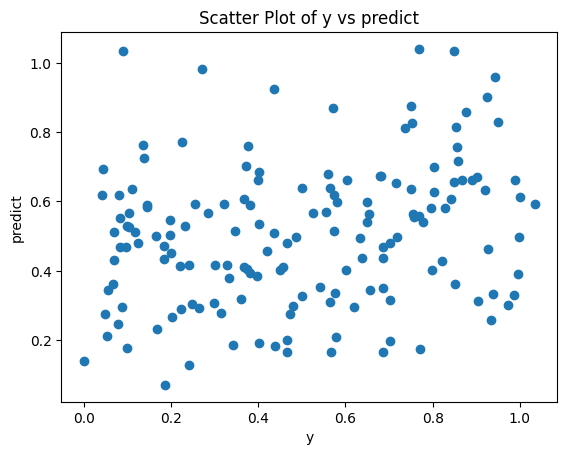

R2 Score: -0.16628912211934876
Mean Absolute Error (MAE): 0.2517806854453057
Root Mean Squared Error (RMSE): 0.31339935666222485


In [13]:
plt.scatter(array_y, array_pre)
plt.xlabel('y')
plt.ylabel('predict')
plt.title('Scatter Plot of y vs predict')
plt.show()

# R2スコアの計算
r2 = r2_score(array_y, array_pre)
print(f"R2 Score: {r2}")

# MAEの計算
mae = mean_absolute_error(array_y, array_pre)
print(f"Mean Absolute Error (MAE): {mae}")

      
      # RMSEの計算
rmse = np.sqrt(mean_squared_error(array_y, array_pre))
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [14]:
array_pre = array_pre.flatten()

In [15]:
combined_array = np.vstack((array_y, array_pre)).T
np.savetxt("stft_cnn_20240606_4.csv", combined_array, delimiter=",", header="y,predict", comments='')

In [16]:
df0 = pd.read_csv("stft_cnn_20240606_0.csv")
print(df0)
df1 = pd.read_csv("stft_cnn_20240606_1.csv")
print(df1)
df2 = pd.read_csv("stft_cnn_20240606_2.csv")
print(df2)
df3 = pd.read_csv("stft_cnn_20240606_3.csv")
print(df3)
df4 = pd.read_csv("stft_cnn_20240606_4.csv")
print(df4)

         y   predict
0    1.045  0.893857
1    0.677  0.623885
2    0.791  0.458902
3    0.069  0.676550
4    0.323 -0.070589
..     ...       ...
153  0.570  0.427727
154  0.830  0.531241
155  0.824  0.841097
156  0.876  1.042310
157  0.999  0.519359

[158 rows x 2 columns]
         y   predict
0    0.215  0.287790
1    0.343  0.511660
2    0.442  0.615001
3    0.064  0.064877
4    0.134  0.324287
..     ...       ...
152  0.559  0.490444
153  0.400  0.292400
154  0.499  0.321912
155  0.472  0.551244
156  0.662  0.677523

[157 rows x 2 columns]
         y   predict
0    0.446  0.389901
1    0.862  0.409784
2    0.281  0.446852
3    0.600  0.655110
4    0.099  0.497841
..     ...       ...
152  0.375  0.248908
153  0.383  0.383159
154  0.599  0.783591
155  0.723  0.431893
156  0.934  0.794962

[157 rows x 2 columns]
         y   predict
0    0.264  0.287141
1    0.251  0.576503
2    0.000  0.152607
3    0.440  0.390783
4    0.169  0.380915
..     ...       ...
309  0.064  0.226314
310 

In [17]:
df = [df0, df1, df2, df3, df4]
combined_df = pd.concat(df, ignore_index=True)

# 結合したDataFrameを表示
print(combined_df)

         y   predict
0    1.045  0.893857
1    0.677  0.623885
2    0.791  0.458902
3    0.069  0.676550
4    0.323 -0.070589
..     ...       ...
938  0.300  0.415812
939  0.634  0.494824
940  0.572  0.871051
941  0.736  0.811253
942  0.944  0.958134

[943 rows x 2 columns]


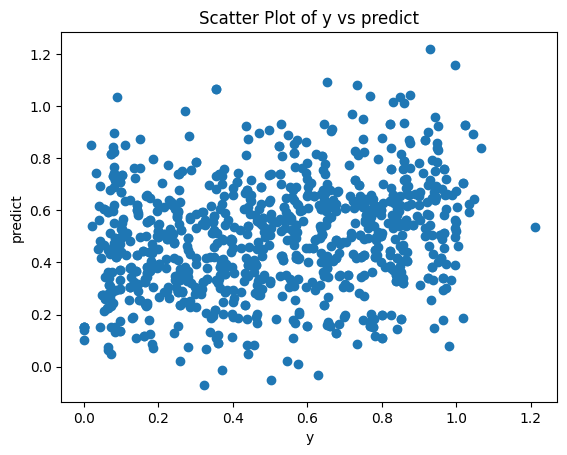

R2 Score: -0.18224444492339797
Mean Absolute Error (MAE): 0.2543389245957642
Root Mean Squared Error (RMSE): 0.3137364125943031


In [18]:
plt.scatter(combined_df['y'], combined_df['predict'])
plt.xlabel('y')
plt.ylabel('predict')
plt.title('Scatter Plot of y vs predict')
plt.show()

# R2スコアの計算
r2 = r2_score(combined_df['y'], combined_df['predict'])
print(f"R2 Score: {r2}")

# MAEの計算
mae = mean_absolute_error(combined_df['y'], combined_df['predict'])
print(f"Mean Absolute Error (MAE): {mae}")

      
      # RMSEの計算
rmse = np.sqrt(mean_squared_error(combined_df['y'], combined_df['predict']))
print(f"Root Mean Squared Error (RMSE): {rmse}")